<a href="https://colab.research.google.com/github/williamdaburke/accounts_classification_toy/blob/master/accounts_classification_toy__tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

import re
import warnings
import math
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import naive_bayes, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
#from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

import nltk, spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
data_df = pd.read_csv("https://www.dropbox.com/sh/iwic23m3rny73ot/AAAITq9NI0B_3wVIoYByln4ya/interviews/data-problem/sample.csv?dl=1",names=['text','tags'])
data_df.shape
data_df.head(20)

(700, 2)

,text,tags
0,Depreciation of tangible fixed assets - owned ...,d_and_a
1,Cost of equity settled share based payments,adjustment
2,Amortisation of software,d_and_a
3,Auditor's remuneration: Audit,other
4,Operating lease payables - equipment,other
5,Fees payable to the company's auditors and its...,other
6,Auditor's remuneration audit services statutor...,other
7,Exceptional onerous contracts,adjustment
8,Profit/loss on disposal of fixed assets,adjustment
9,Audit services,other


<Figure size 504x72 with 0 Axes>

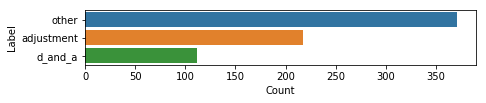


 mu = 6.23 and sigma = 3.32



Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'wordcount distribution')

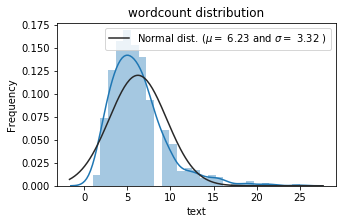

In [0]:
all_labels = nltk.FreqDist(data_df["tags"].values)
all_labels_df = pd.DataFrame({'Label': list(all_labels.keys()), 'Count': list(all_labels.values())})

g = all_labels_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(7,1))
ax = sns.barplot(data=g, x= "Count", y = "Label")
#ax.set(ylabel = 'Label')

plt.show()

txt_lengths = data_df['text'].str.split().apply(lambda x: len(x))
f = sns.distplot(txt_lengths, fit=norm);
f.figure.set_size_inches(5,3)
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(txt_lengths)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('wordcount distribution')

In [0]:
additional_stops = ['com','www','http','https']
stop_words = set(stopwords.words('english')+additional_stops)

def clean_text(text):
    text = re.sub("\'", "", text)
    #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub("[^a-z]"," ",text.lower())
    #text = re.sub(r'(.)\1+', r'\1\1', text)
    text = ' '.join([w for w in text.split() if not w in stop_words])
    #performs slightly better without lemmatization it seems
    #text = ' '.join(lemmatize(text))
    return text
  
data_df['clean_text'] = data_df['text'].apply(lambda x: clean_text(x))

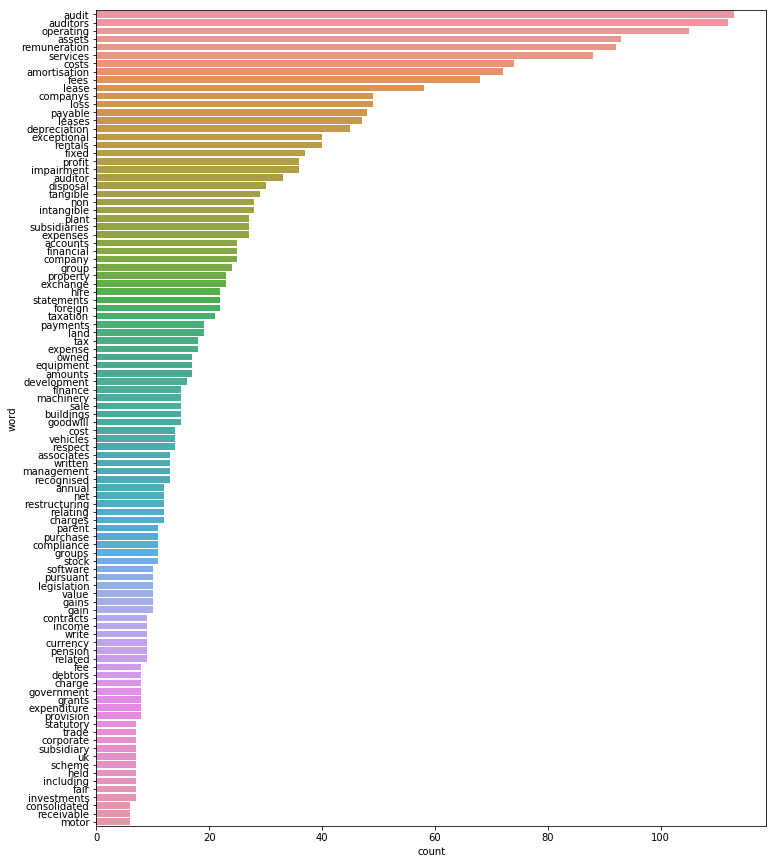

In [0]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  plt.show()
  
freq_words(data_df['clean_text'], 100)

In [0]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
X_rs, y_rs = sampler.fit_sample(data_df[['clean_text']].values, data_df['tags'])

#plot_this(X_rs,y_rs,'Random undersampling')

np.squeeze(X_rs).shape, y_rs.shape


xtrain, xval, ytrain, yval = train_test_split(np.squeeze(X_rs), y_rs, test_size=0.2, random_state=7)

((1113,), (1113,))

In [0]:
def make_classifier_pipeline(model):
  return Pipeline([
      ('vectorizer', CountVectorizer(lowercase=True, 
                                     stop_words='english', 
                                     max_df=0.8, 
                                     min_df=1)),
      ('tfidf', TfidfTransformer()),
      ('clf', OneVsRestClassifier(model))])

In [0]:
def get_best_tags(clf, X, lb, n_tags=3):
    decfun = clf.decision_function(X)
    best_tags = np.argsort(decfun)[:, :-(n_tags+1): -1]
    return best_tags #lb.classes_[best_tags]

padding_print = " \n ###########################################################\n "

n_estimators = 10
models_dict = {
          "bayes":{"model":naive_bayes.MultinomialNB()}
          ,"rf":{"model":RandomForestClassifier(n_estimators=200, max_depth=3)}
          ,"lr":{"model":LogisticRegression()}
          ,
          "linearsvc":{"model":LinearSVC()}
          #computation is usually too expensive for svc('linear'), but possible here on small dataset  #
          ,"svm":{"model":BaggingClassifier(svm.SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)}
         }
          
results_df = pd.DataFrame(columns = ['model','f1'])

def train_and_report():
  results_df = pd.DataFrame(columns = ['model','f1'])
  
  with warnings.catch_warnings(record=True) as received_warnings:
    warnings.simplefilter("always")
    for m in models_dict.keys():
      models_dict[m]['clf'] = make_classifier_pipeline(models_dict[m]['model'])
      models_dict[m]['clf'].fit(xtrain, ytrain)

      if m == "linearsvc":
        models_dict[m]['y_pred'] = models_dict[m]['clf'].predict(xval)
        models_dict[m]['y_pred_decfun'] = get_best_tags(models_dict[m]['clf'],xval,mlb)
      else:
        models_dict[m]['y_pred'] = models_dict[m]['clf'].predict(xval)
      
      models_dict[m]['f1'] = f1_score(yval, models_dict[m]['y_pred'], average="micro")
      print(padding_print,m,' f1: ',models_dict[m]['f1'],padding_print)
      results_df = results_df.append({"model":m,'f1':models_dict[m]['f1']}, ignore_index=True)
  return results_df, received_warnings

In [0]:
results_df, received_warnings = train_and_report()

 
 ###########################################################
  bayes  f1:  0.905829596412556  
 ###########################################################
 
 
 ###########################################################
  rf  f1:  0.9192825112107623  
 ###########################################################
 
 
 ###########################################################
  lr  f1:  0.9461883408071748  
 ###########################################################
 
 
 ###########################################################
  linearsvc  f1:  0.9641255605381166  
 ###########################################################
 
 
 ###########################################################
  svm  f1:  0.9461883408071748  
 ###########################################################
 


In [0]:
print(models_dict['linearsvc']['clf'].predict(['final amortisation of computer programs in warehouse']))
print(models_dict['linearsvc']['clf'].predict(['fish in the oven']))
print(models_dict['linearsvc']['clf'].predict(['cost of convertible loans']))

['d_and_a']
['other']
['adjustment']


In [0]:
report_df = pd.DataFrame(classification_report(yval, models_dict['linearsvc']['y_pred'], output_dict=True)).transpose()
report_df

,f1-score,precision,recall,support
adjustment,0.948718,0.936709,0.961039,77.000000
d_and_a,1.000000,1.000000,1.000000,70.000000
other,0.946667,0.959459,0.934211,76.000000
accuracy,0.964126,0.964126,0.964126,0.964126
macro avg,0.965128,0.965389,0.965083,223.000000
weighted avg,0.964116,0.964330,0.964126,223.000000
